In [13]:
from src.HestonModel import generate_heston_paths
import numpy as np
import esig
import matplotlib.pyplot as plt
import iisignature
import signatory
import torch
from tqdm.auto import tqdm

In [14]:
# constant Heston parameters
kappa = 3
theta = 0.02
v_0 = theta #
rho = 0.75
sigma = 0.6
r = 0.04

S = 100
paths = 10000
steps = 50
T = 1

In [15]:
# Get Heston prices and volatilises
prices, sigs = generate_heston_paths(S, T, r, kappa, theta, v_0, rho, sigma, steps, paths, return_vol=True)

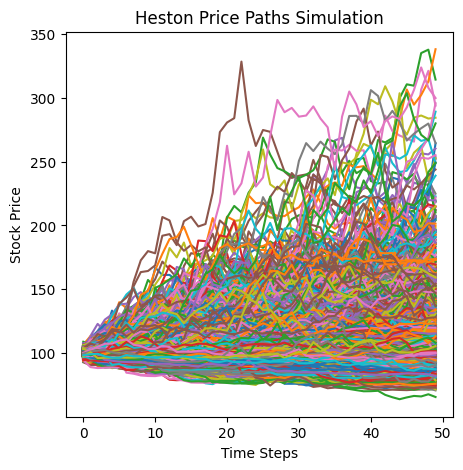

In [17]:
# Plot Heston Price paths
plt.figure(figsize=(5, 5))
plt.plot(prices.T)
plt.title('Heston Price Paths Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

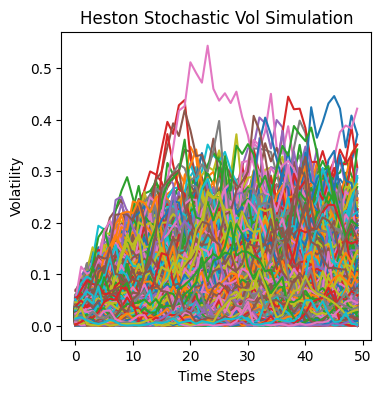

In [18]:
# Plot Heston volatility paths
plt.figure(figsize=(4, 4))
plt.plot(sigs.T)
plt.title('Heston Stochastic Vol Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.show()

In [19]:
#############################################################################################

In [66]:
thetas= np.random.uniform(0.01,0.8,500) #Long run variance θ
kappas= 2 # Mean reversion κ
v_0s = thetas #  Initial variance
rhos = 0.6 #Correlation ρ, correlation between the log-returns and volatility of the asset
sigmas = 0.6 #Volatility of variance σ
rs = 0.04

S = 100
paths = 10000
steps = 100
T = 1

In [67]:
depth_of_sig=2  #level of truncation of signatures
width_of_sig=3  # prices + sigmas + time_array (parameters for signatures)
sig_keys = esig.sigkeys(width_of_sig, depth_of_sig)
sig_dim=signatory.signature_channels(width_of_sig,depth_of_sig)

In [68]:
# define time_array and empty tensor for prices and sigmas, signatures and expected signatures
time_array = np.arange(steps)
prices_and_sigs_with_time_tensor = torch.zeros((paths,steps, width_of_sig ))
number_of_loops=thetas.shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape
number_of_loops
prices_and_sigs_with_time_tensor.shape

torch.Size([10000, 100, 3])

In [69]:
def signatures_calculations_thetas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for theta in thetas:
            # Caclulation of 10000 paths of prices and sigmas
            prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths, return_vol=True)

            for j in range(paths):
                     prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                    #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

            sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
            #     shape of  sign_ps_signatory_differentranges=torch.Size([500, 10000, 12])

            Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
            #     shape of  Exp_sign_signatory_results=torch.Size([500, 12])

            count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [70]:
results_thetas=signatures_calculations_thetas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_thetas=results_thetas[0]
Exp_signatures_results_thetas=results_thetas[1]

In [26]:
Exp_signatures_results_thetas.shape

torch.Size([500, 12])

In [27]:
signatures_results_thetas.shape

torch.Size([500, 10000, 12])

In [28]:
signatures_results_thetas[0].shape

torch.Size([10000, 12])

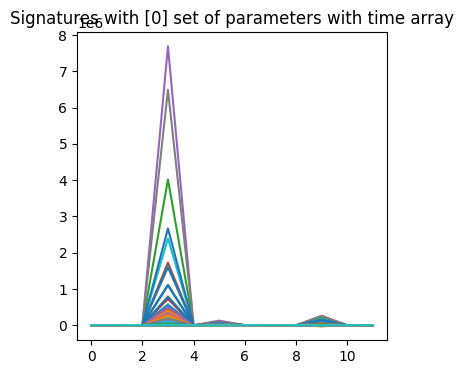

In [29]:
plt.figure(figsize=(4, 4))
plt.plot(signatures_results_thetas[0].T)  #there are 512 sets of parameters
plt.title("Signatures with [0] set of parameters with time array")
plt.show()

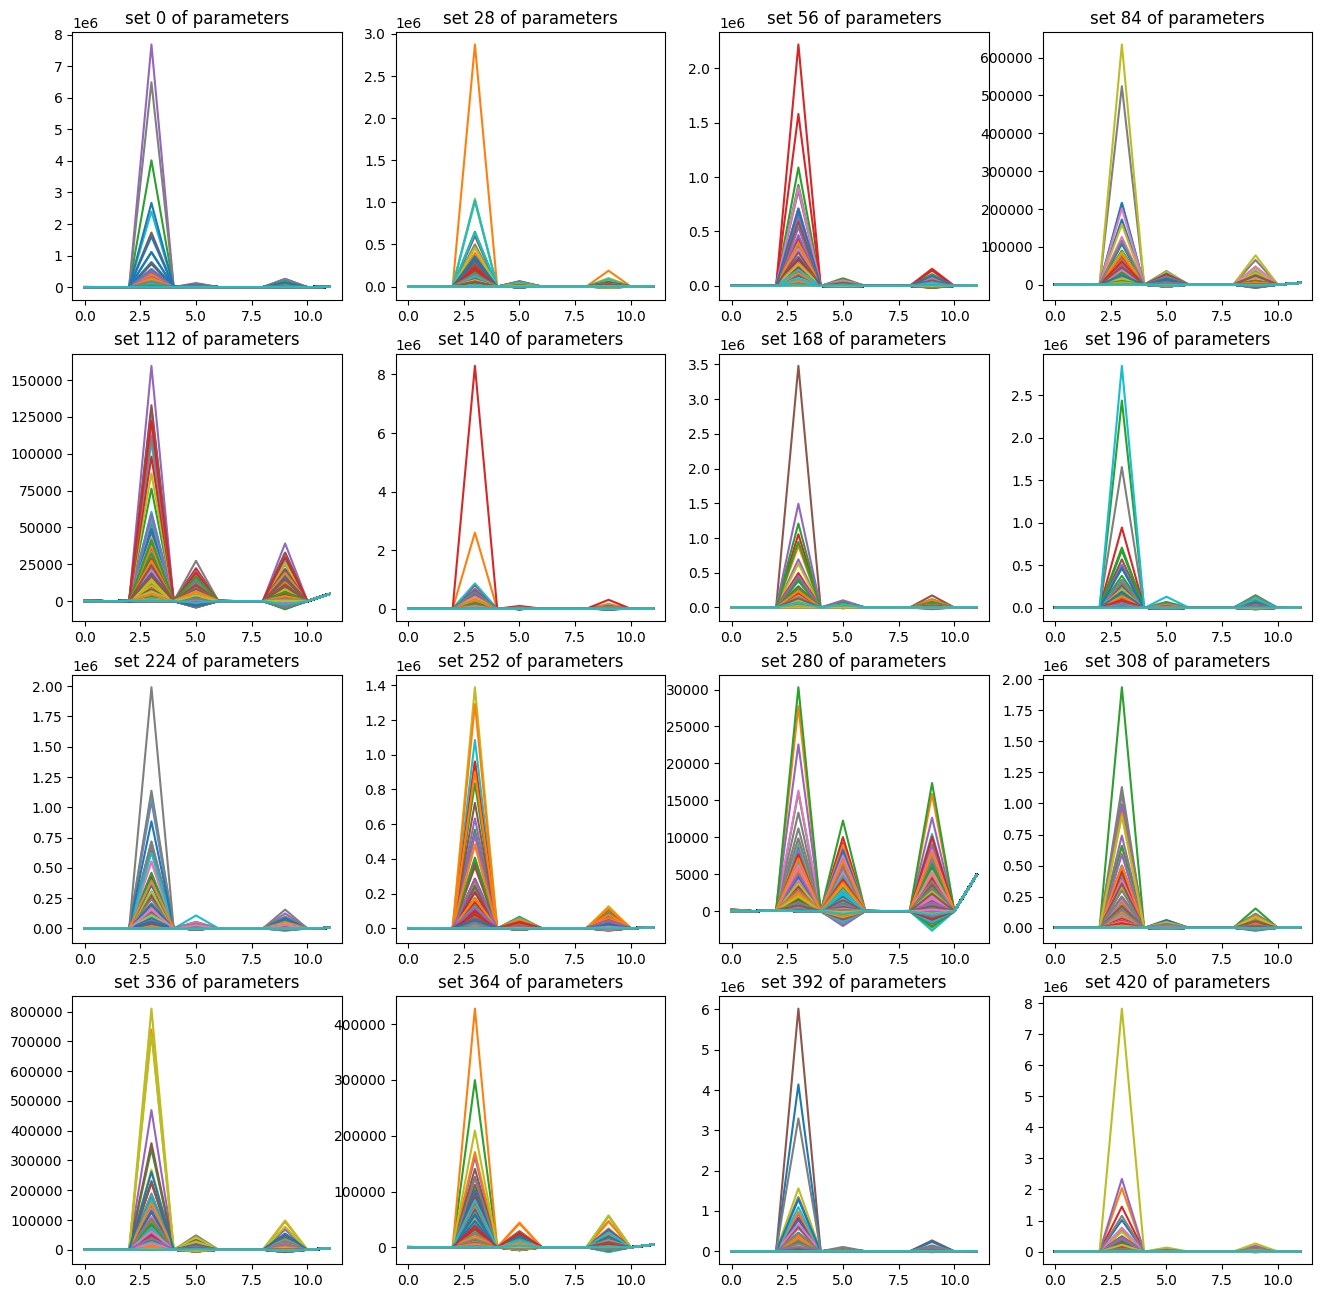

In [30]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text("set " + str(i*28)+" of parameters")
    ax.plot(signatures_results_thetas[i*28].T)
#     Plot 10000 signatures for each set of parameters
#     There are big changes on each plot, which are formed on the signature keys (1,1), (1,3), (3,1)

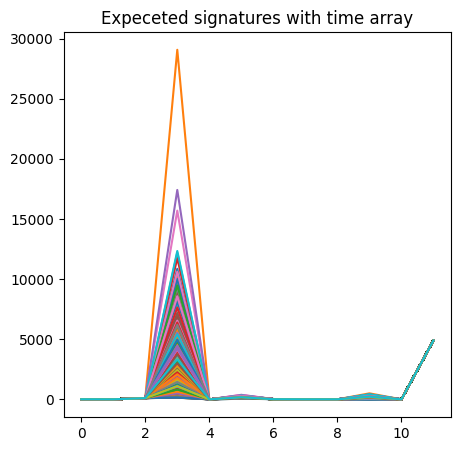

In [31]:
plt.figure(figsize=(5, 5))
plt.plot(Exp_signatures_results_thetas.T[:])
plt.title("Expeceted signatures with time array")
plt.show()
# Plot 500 expected signatures

In [32]:
Exp_signatures_results_thetas.T.shape

torch.Size([12, 500])

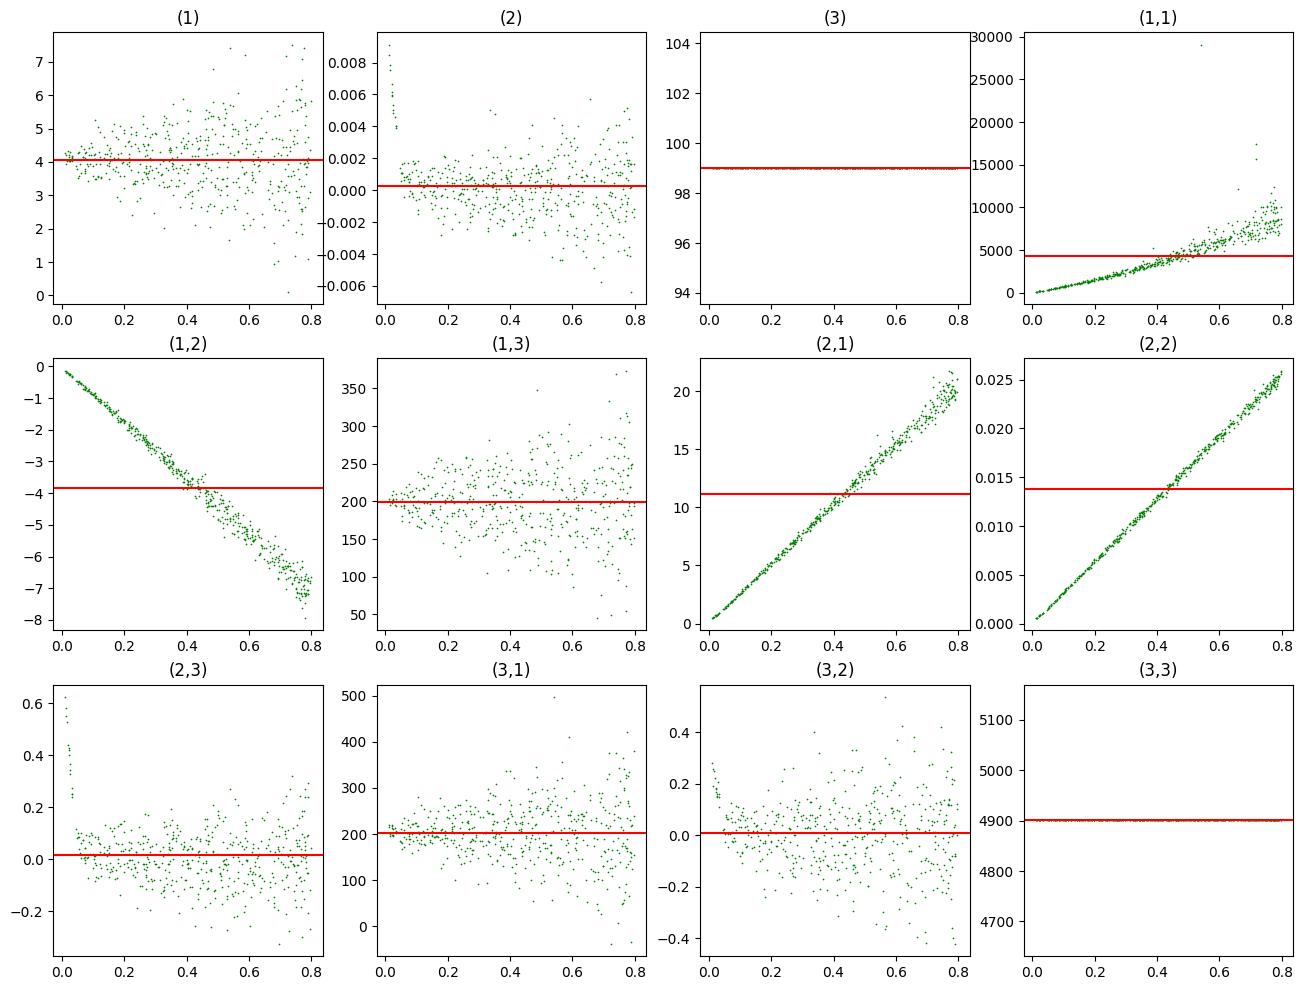

In [35]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(thetas,Exp_signatures_results_thetas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_thetas.T[i]), color='red')

#     For each key of the signature, plot the evolving Expected Signature depending on the sigmas's values
#     We can note, that most of the keys of the expected signature depend on theta's value. Namely, the bigger theta we have the
#     higher value of the key, especially for keys that depend on theta we can highlight ( (1,1), (2,1), (2,2)).
#     However, the key (1,2) has the complete opposite trend, i.e. as the value of theta increases, so does the value of Key (1,2).

#     For time keys like (3) and (3,3) we have constant, since it does not change from the parameters
#     However, for the keys (1), (2), (1,3), (2,3), (3,2) and (3,1) we cannot say a lot in particular, besides that they have a big
#     volatility and that volatility grows as theta grows. But (2) and (2,3) for small theta have bigger values, which are sharply
#     reduced by a slight increase of theta

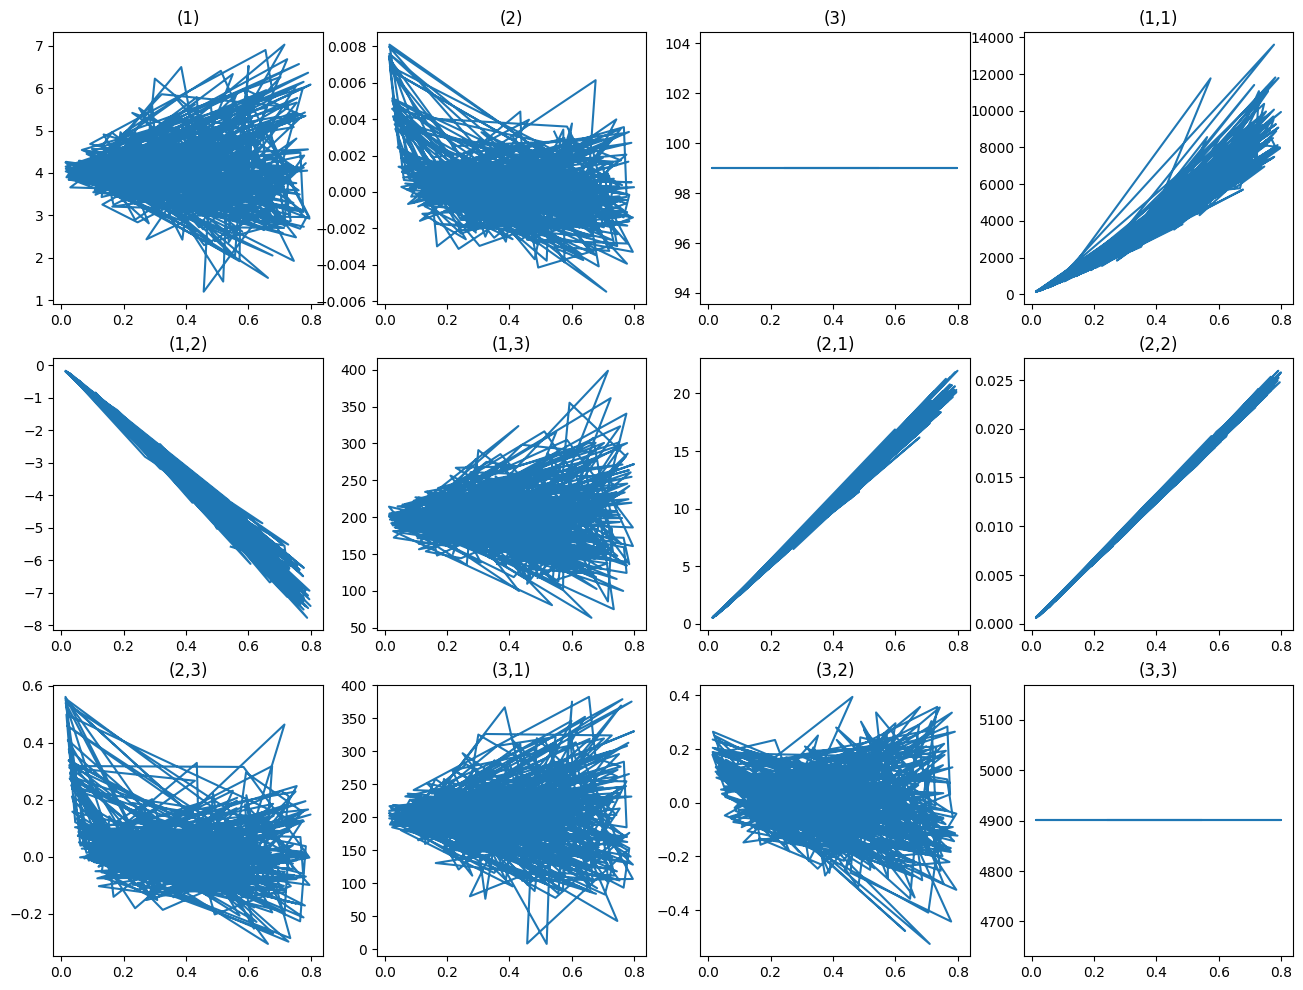

In [71]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(thetas,Exp_signatures_results_thetas.T[i])
    # ax.set_xticks([0,60,120, 180,240,300,360,420,480],[round(x,3) for x in list(thetas[[0,60,120, 180,240,300,360,420,480]])])

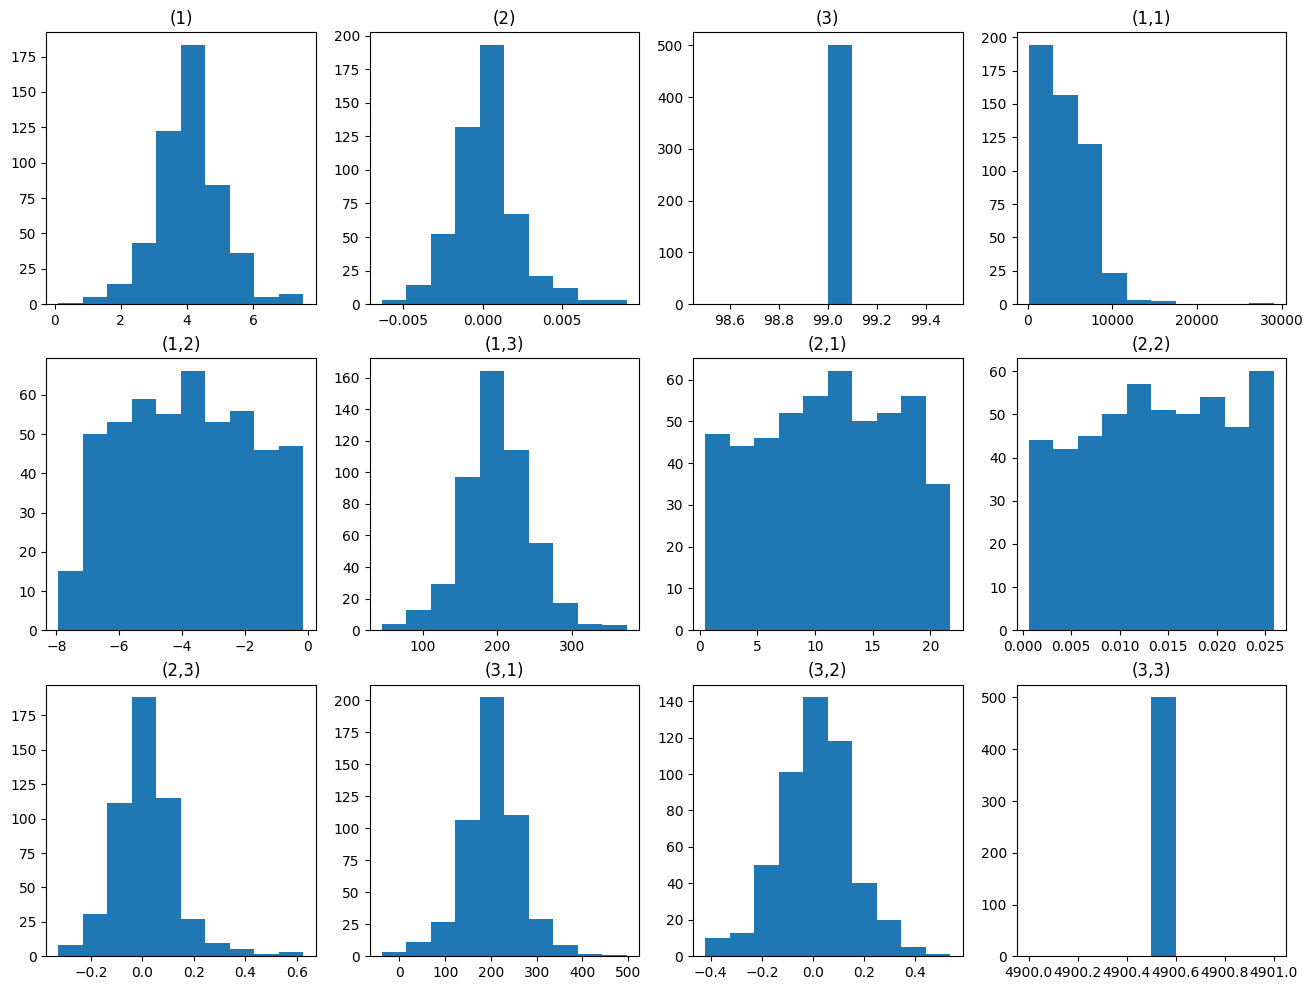

In [37]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.hist(Exp_signatures_results_thetas.T[i])

# Although, if you change the order of parameters in the function "signatures_calculations_with_timearray",
# the graphs of each Expected signature key are different, their histograms are similar.

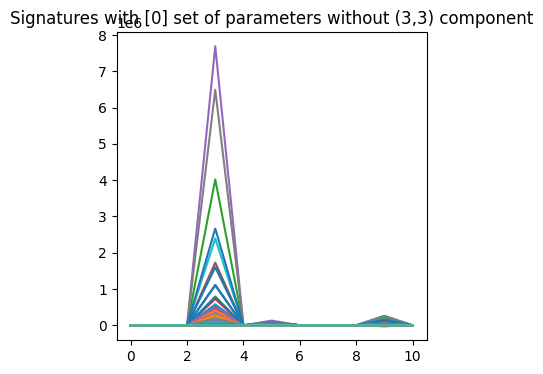

In [38]:
plt.figure(figsize=(4, 4))
plt.plot(signatures_results_thetas[0].T[:-1])  #there are 500 sets of parameters #excluded the last component to better understand the graph, since its value is too big
plt.title("Signatures with [0] set of parameters without (3,3) component")
plt.show()

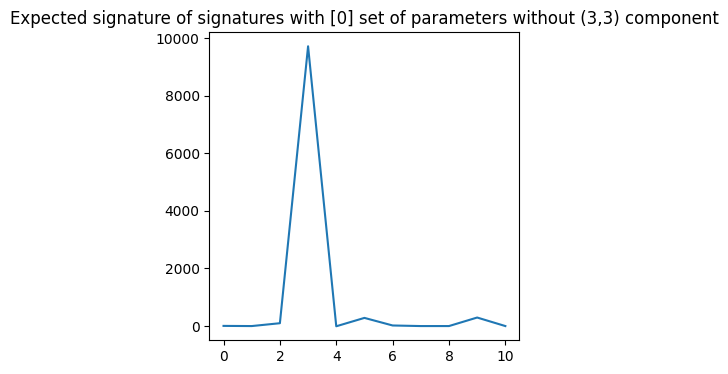

In [39]:
plt.figure(figsize=(4, 4))
plt.plot(Exp_signatures_results_thetas[0].T[:-1])  #there are 500 sets of parameters #exclude last component, since its value is too big
plt.title("Expected signature of signatures with [0] set of parameters without (3,3) component")
plt.show()

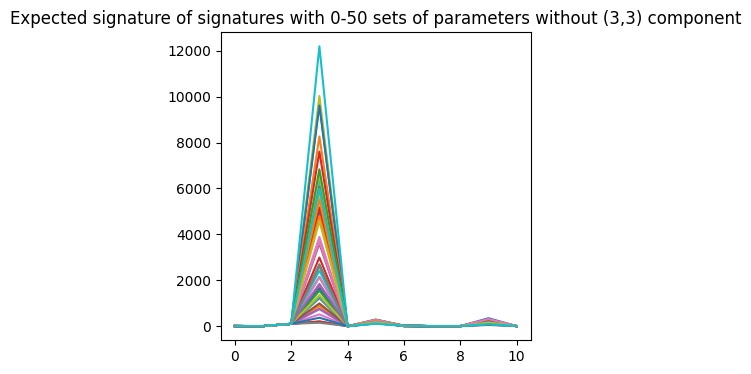

In [40]:
plt.figure(figsize=(4, 4))
plt.plot(Exp_signatures_results_thetas[:50].T[:-1])  #there are 500 sets of parameters #exclude last component, since its value is too big
plt.title("Expected signature of signatures with 0-50 sets of parameters without (3,3) component")
plt.show()

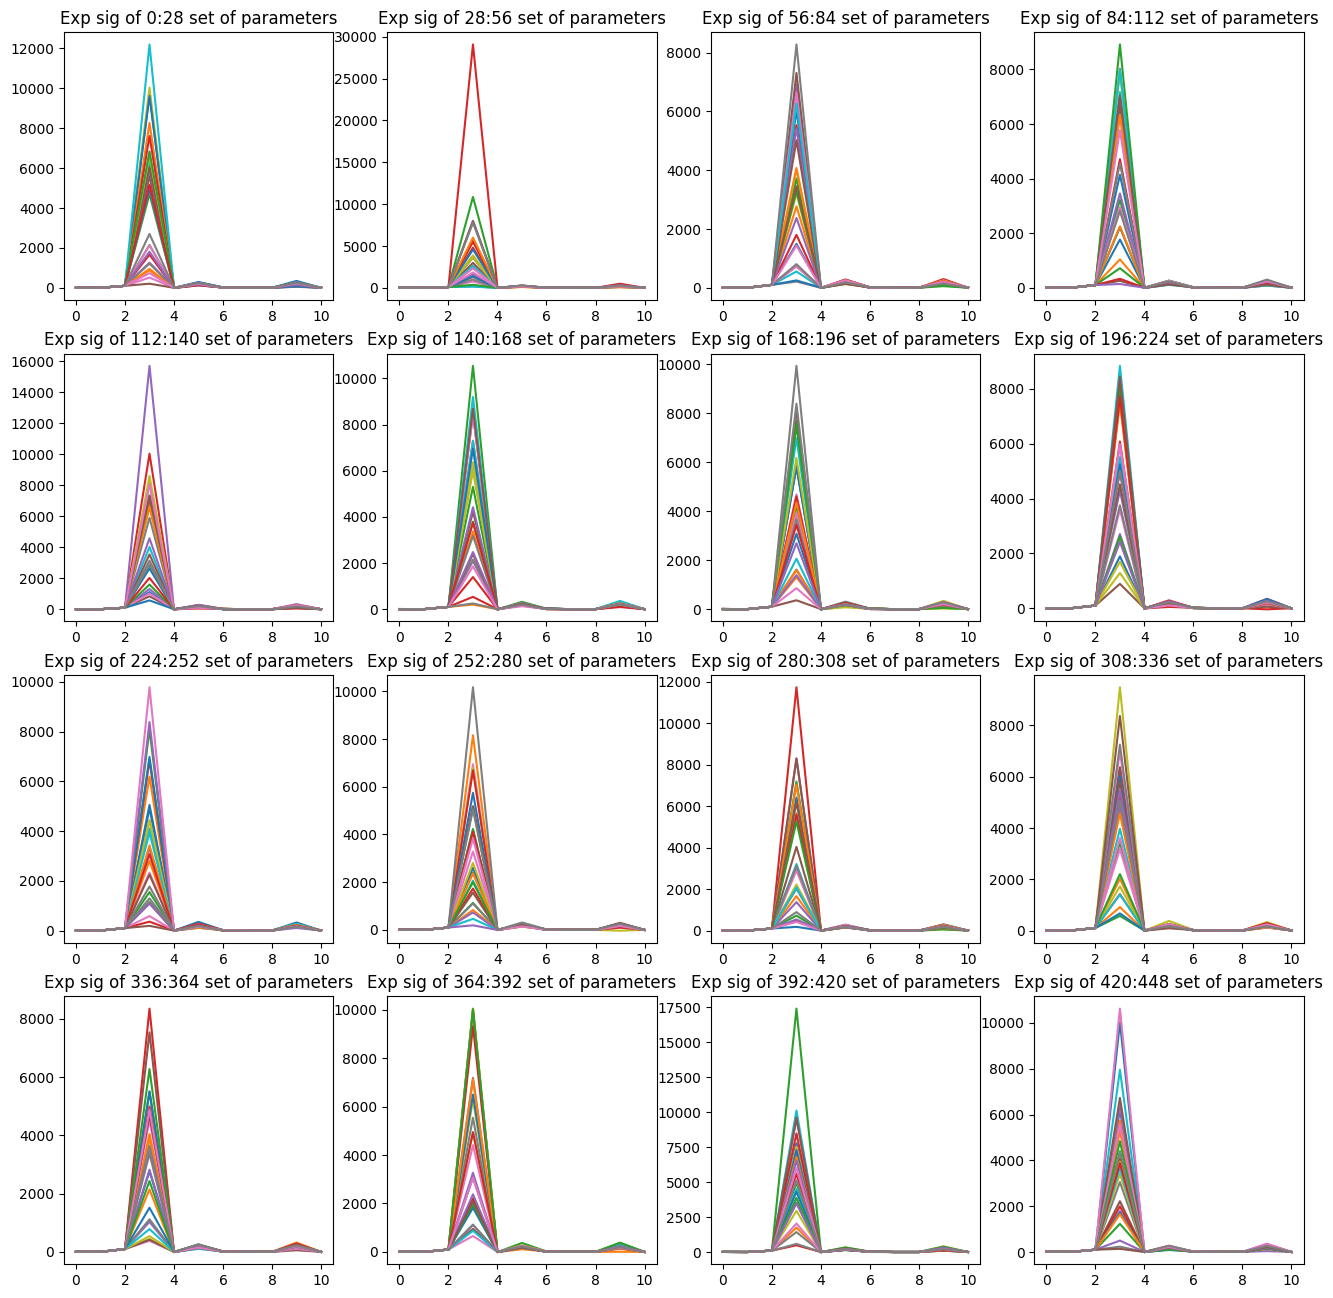

In [41]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text("Exp sig of "  + str(i*28)+":"+ str((i+1)*28)+" set of parameters")
    ax.plot(Exp_signatures_results_thetas[i*28:(i+1)*28].T[:-1]) #for better illustration exclude last component, since its value is too big

In [42]:
# change kappa to 0.1
thetas= np.random.uniform(0.01,0.8,500) #Long run variance θ
kappas= 0.1 # 2
v_0s = thetas #  Initial variance
rhos = 0.6 #Correlation ρ, correlation between the log-returns and volatility of the asset
sigmas = 0.6 #Volatility of variance σ
rs = 0.04

S = 100
paths = 10000
steps = 100
T = 1

In [43]:
results_thetas=signatures_calculations_thetas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_thetas=results_thetas[0]
Exp_signatures_results_thetas=results_thetas[1]

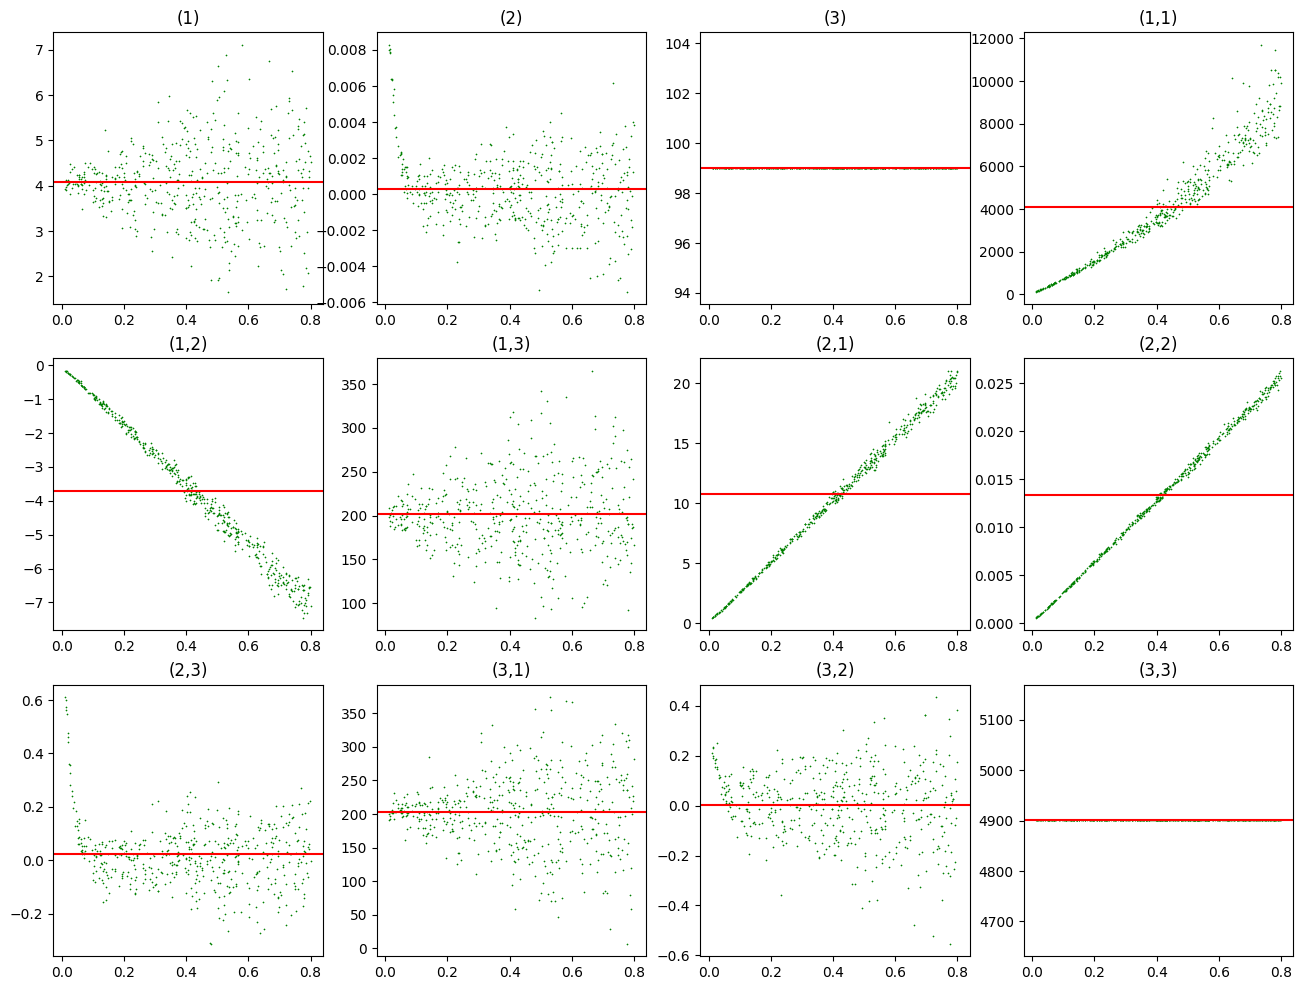

In [44]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(thetas,Exp_signatures_results_thetas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_thetas.T[i]), color='red')

# seems that for most of components we do not have valuable changes
# thus small kappas has no big influence on expected signature components with variable sigmas

In [45]:
# change kappa to 8.0
thetas= np.random.uniform(0.01,0.8,500) #Long run variance θ
kappas= 8.0 # 2
v_0s = thetas #  Initial variance
rhos = 0.6 #Correlation ρ, correlation between the log-returns and volatility of the asset
sigmas = 0.6 #Volatility of variance σ
rs = 0.04

S = 100
paths = 10000
steps = 100
T = 1

In [46]:
results_thetas=signatures_calculations_thetas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_thetas=results_thetas[0]
Exp_signatures_results_thetas=results_thetas[1]

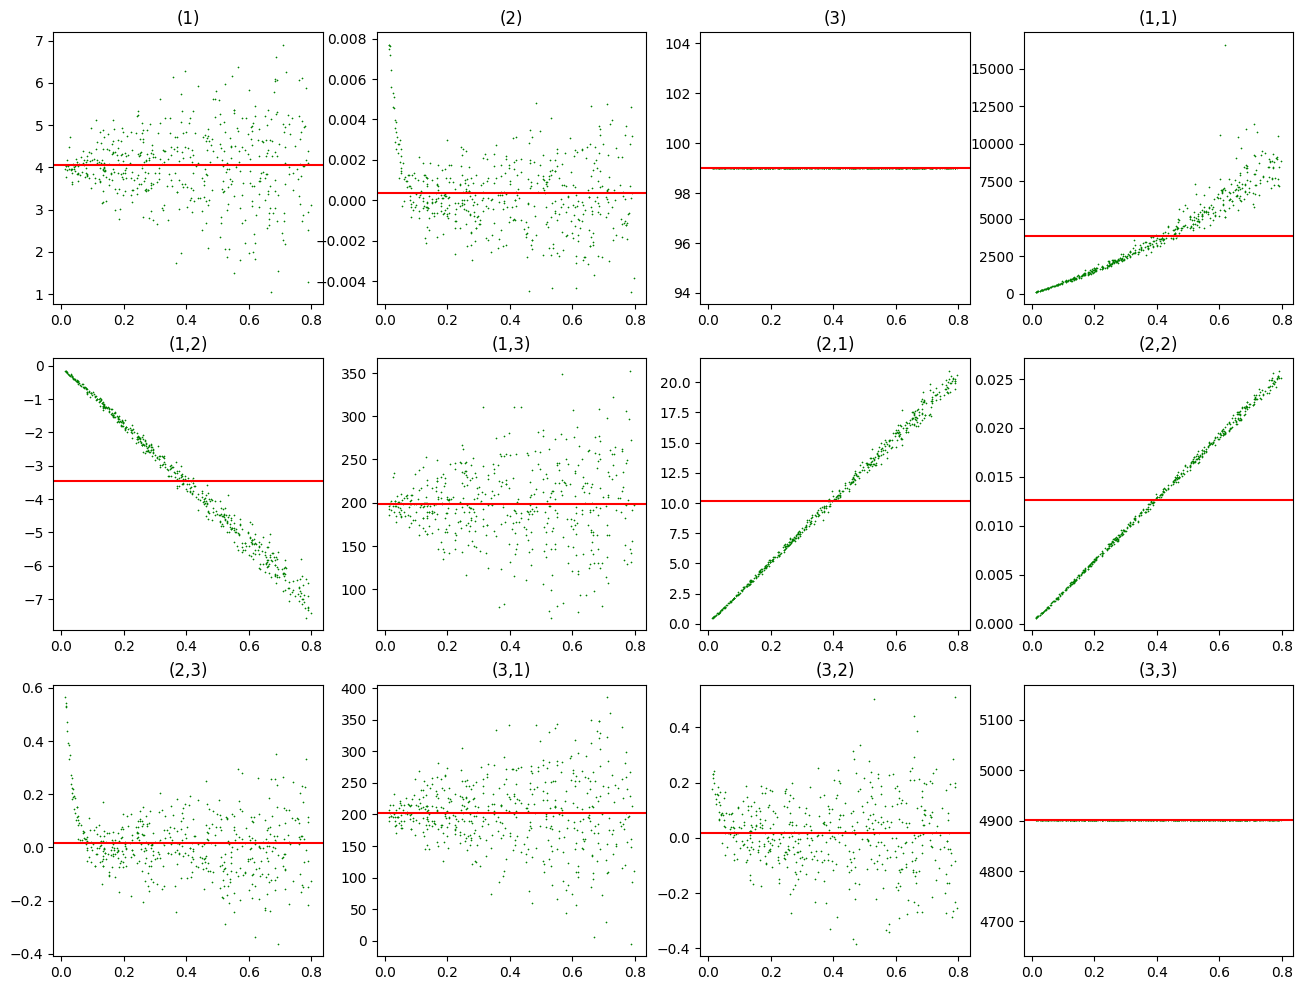

In [47]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(thetas,Exp_signatures_results_thetas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_thetas.T[i]), color='red')

# seems that for most of components we do not have valuable changes
# thus big kappas has no big influence on expected signature components with variable sigmas

In [48]:
# change sigmas to 2.0
thetas= np.random.uniform(0.01,0.8,500) #Long run variance θ
kappas= 2.0 # 2
v_0s = thetas #  Initial variance
rhos = 0.6 #Correlation ρ, correlation between the log-returns and volatility of the asset
sigmas = 2.0 #0.6
rs = 0.04

S = 100
paths = 10000
steps = 100
T = 1

In [49]:
results_thetas=signatures_calculations_thetas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_thetas=results_thetas[0]
Exp_signatures_results_thetas=results_thetas[1]

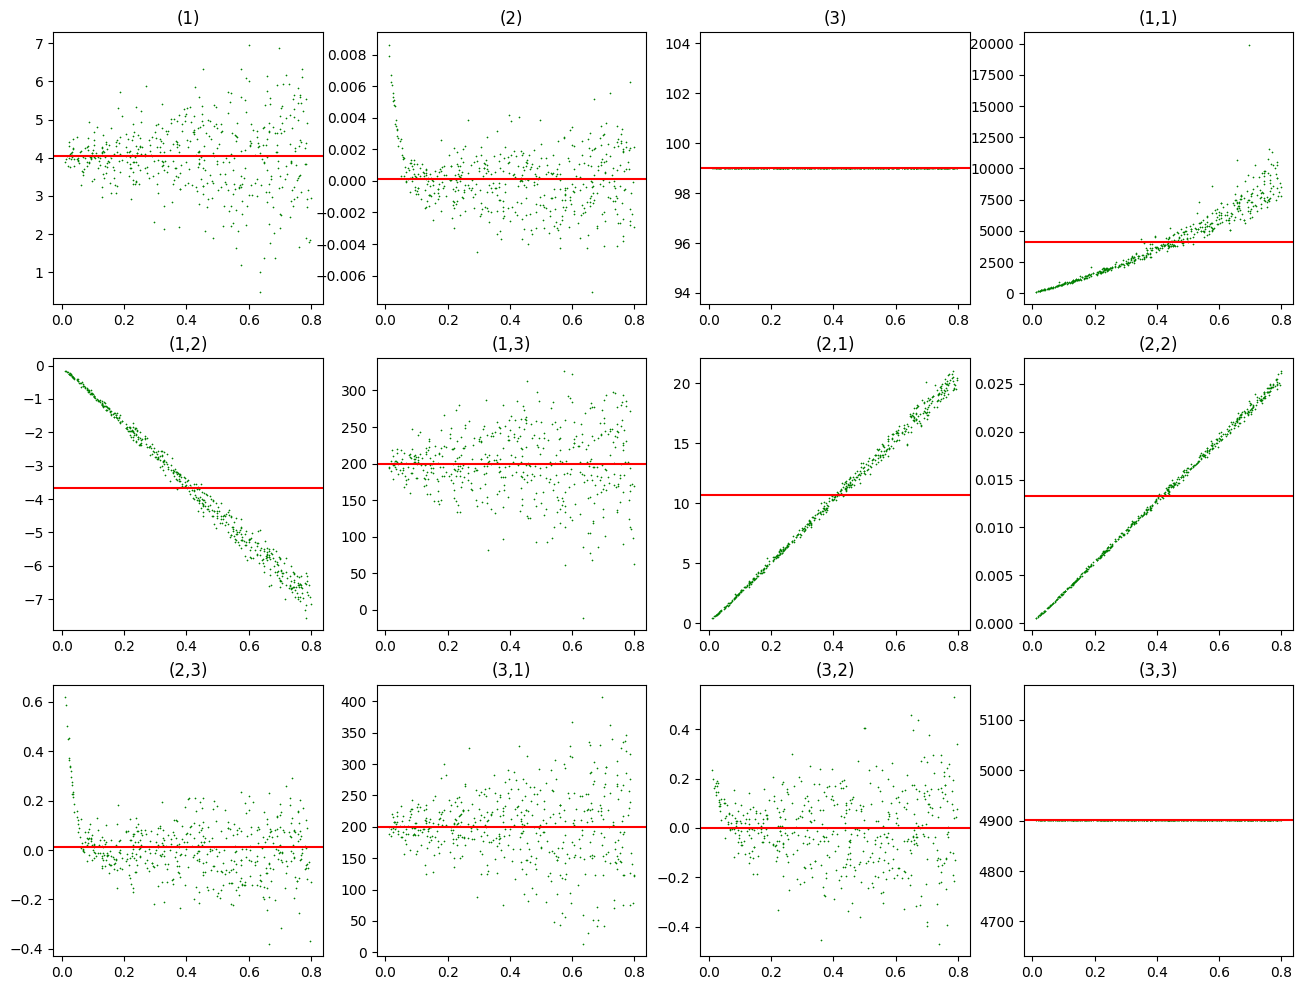

In [50]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(thetas,Exp_signatures_results_thetas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_thetas.T[i]), color='red')

# seems that for most of components we do not have valuable changes, but key (1,1) doesn't have  as many outliers
# thus big sigmas has no big influence on expected signature components with variable sigmas

In [51]:
# change sigmas to 0.05
thetas= np.random.uniform(0.01,0.8,500) #Long run variance θ
kappas= 2.0 # 2
v_0s = thetas #  Initial variance
rhos = 0.6 #Correlation ρ, correlation between the log-returns and volatility of the asset
sigmas = 0.05 #0.6
rs = 0.04

S = 100
paths = 10000
steps = 100
T = 1

In [52]:
results_thetas=signatures_calculations_thetas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_thetas=results_thetas[0]
Exp_signatures_results_thetas=results_thetas[1]

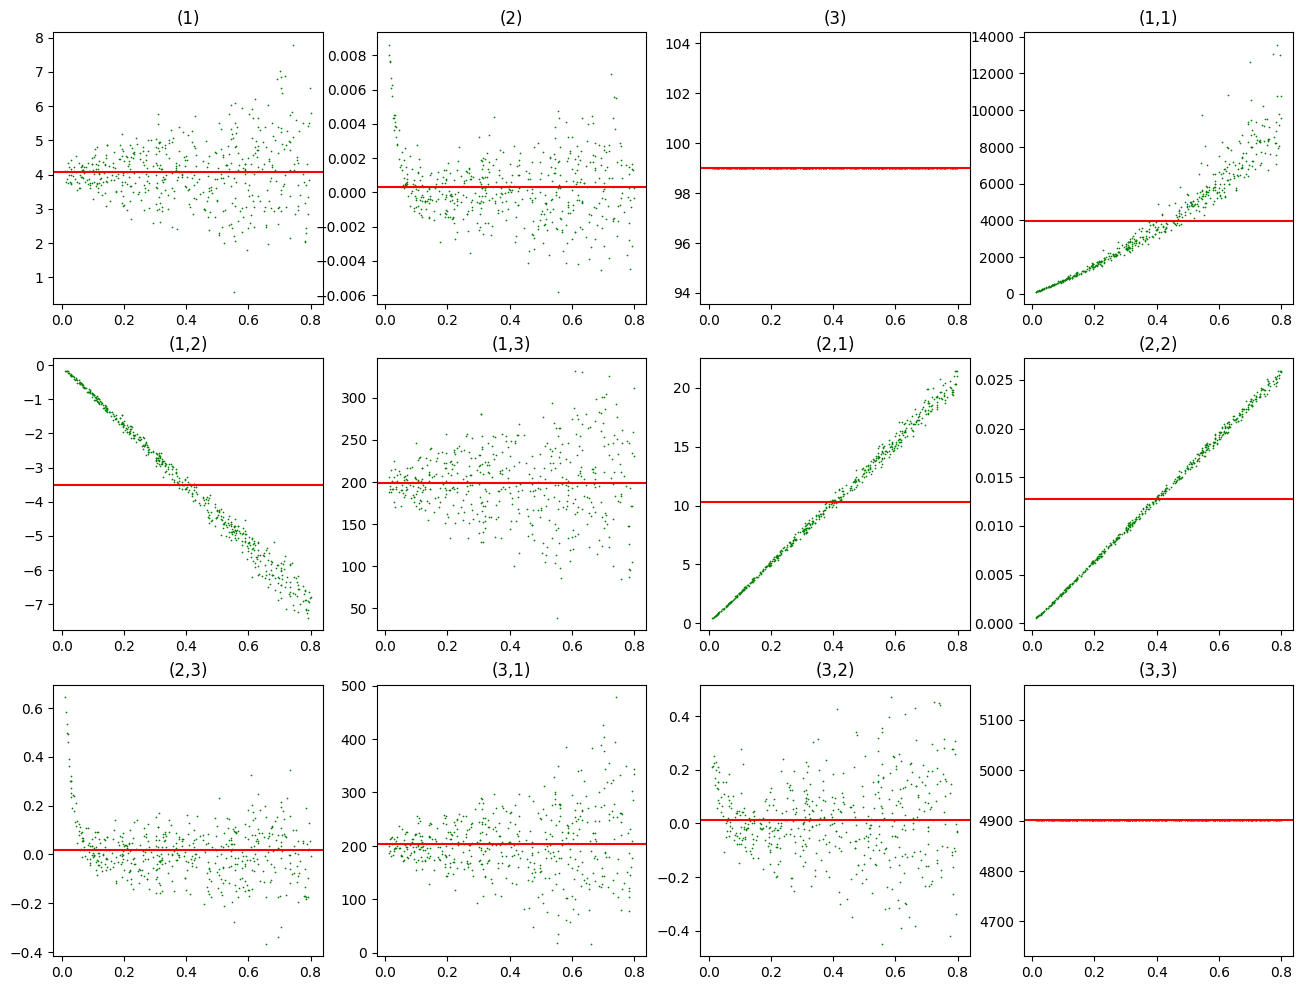

In [53]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(thetas,Exp_signatures_results_thetas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_thetas.T[i]), color='red')

# seems that for most of components we do not have valuable changes, but key (2) have some outliers that a smaller, especially for small thetas
# thus small sigmas has no big influence on expected signature components with variable sigmas

In [54]:
# change rs to 0.005
thetas= np.random.uniform(0.01,0.8,500) #Long run variance θ
kappas= 2.0 # 2
v_0s = thetas #  Initial variance
rhos = 0.6 #Correlation ρ, correlation between the log-returns and volatility of the asset
sigmas = 0.6 #0.6
rs = 0.005 #0.04

S = 100
paths = 10000
steps = 100
T = 1

In [55]:
results_thetas=signatures_calculations_thetas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_thetas=results_thetas[0]
Exp_signatures_results_thetas=results_thetas[1]

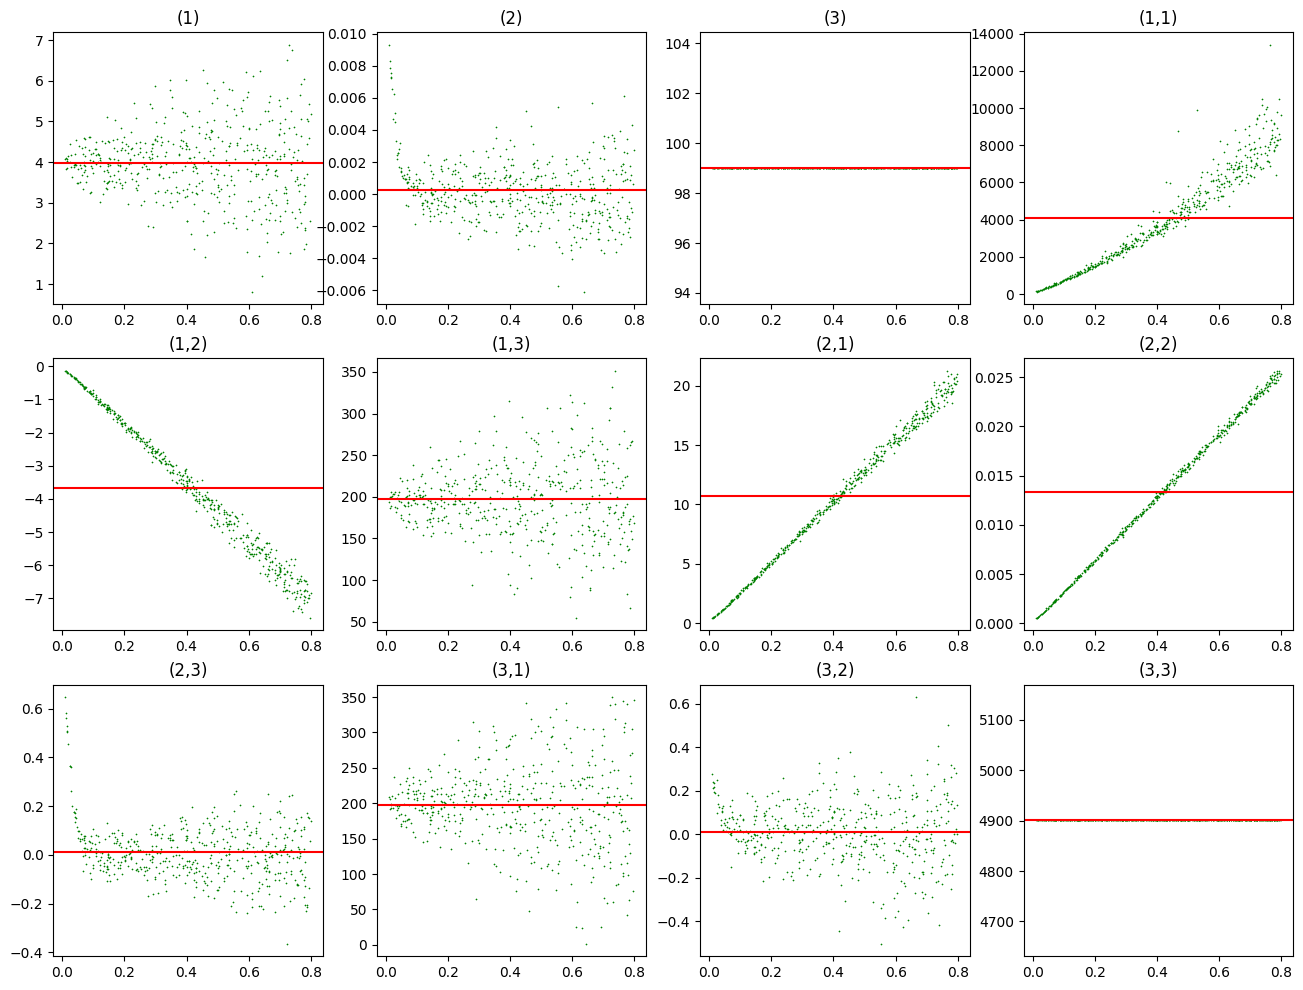

In [56]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(thetas,Exp_signatures_results_thetas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_thetas.T[i]), color='red')

# seems that for most of components we do not have valuable changes
# thus small rs has no big influence on expected signature components with variable sigmas

In [57]:
# change rs to 0.15
thetas= np.random.uniform(0.01,0.8,500) #Long run variance θ
kappas= 2.0 # 2
v_0s = thetas #  Initial variance
rhos = 0.6 #Correlation ρ, correlation between the log-returns and volatility of the asset
sigmas = 0.6 #0.6
rs = 0.15 #0.04

S = 100
paths = 10000
steps = 100
T = 1

In [58]:
results_thetas=signatures_calculations_thetas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_thetas=results_thetas[0]
Exp_signatures_results_thetas=results_thetas[1]

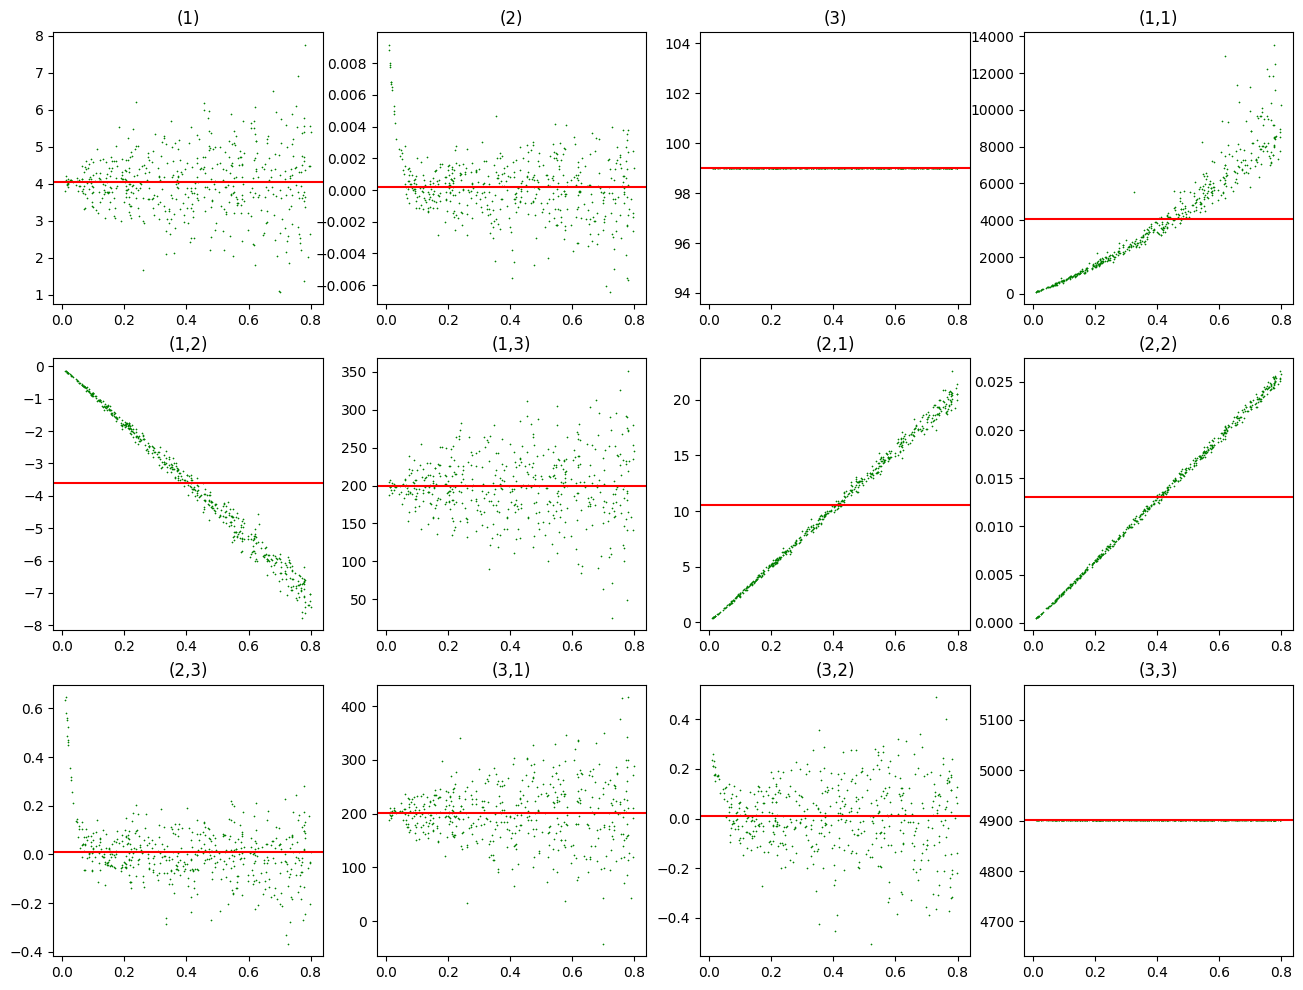

In [59]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(thetas,Exp_signatures_results_thetas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_thetas.T[i]), color='red')

# seems that for most of components we do not have valuable changes, but key (1,1) have some outlires with a big values. Also, keys (1), (1,3), (3,1) and (3,2) have some big outlires
# thus big rs has no big influence on expected signature components with variable sigmas

In [60]:
# change rhos to 0.01
thetas= np.random.uniform(0.01,0.8,500) #Long run variance θ
kappas= 2.0 # 2
v_0s = thetas #  Initial variance
rhos = 0.01 #0.6
sigmas = 0.6 #0.6
rs = 0.04 #0.04

S = 100
paths = 10000
steps = 100
T = 1

In [61]:
results_thetas=signatures_calculations_thetas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_thetas=results_thetas[0]
Exp_signatures_results_thetas=results_thetas[1]

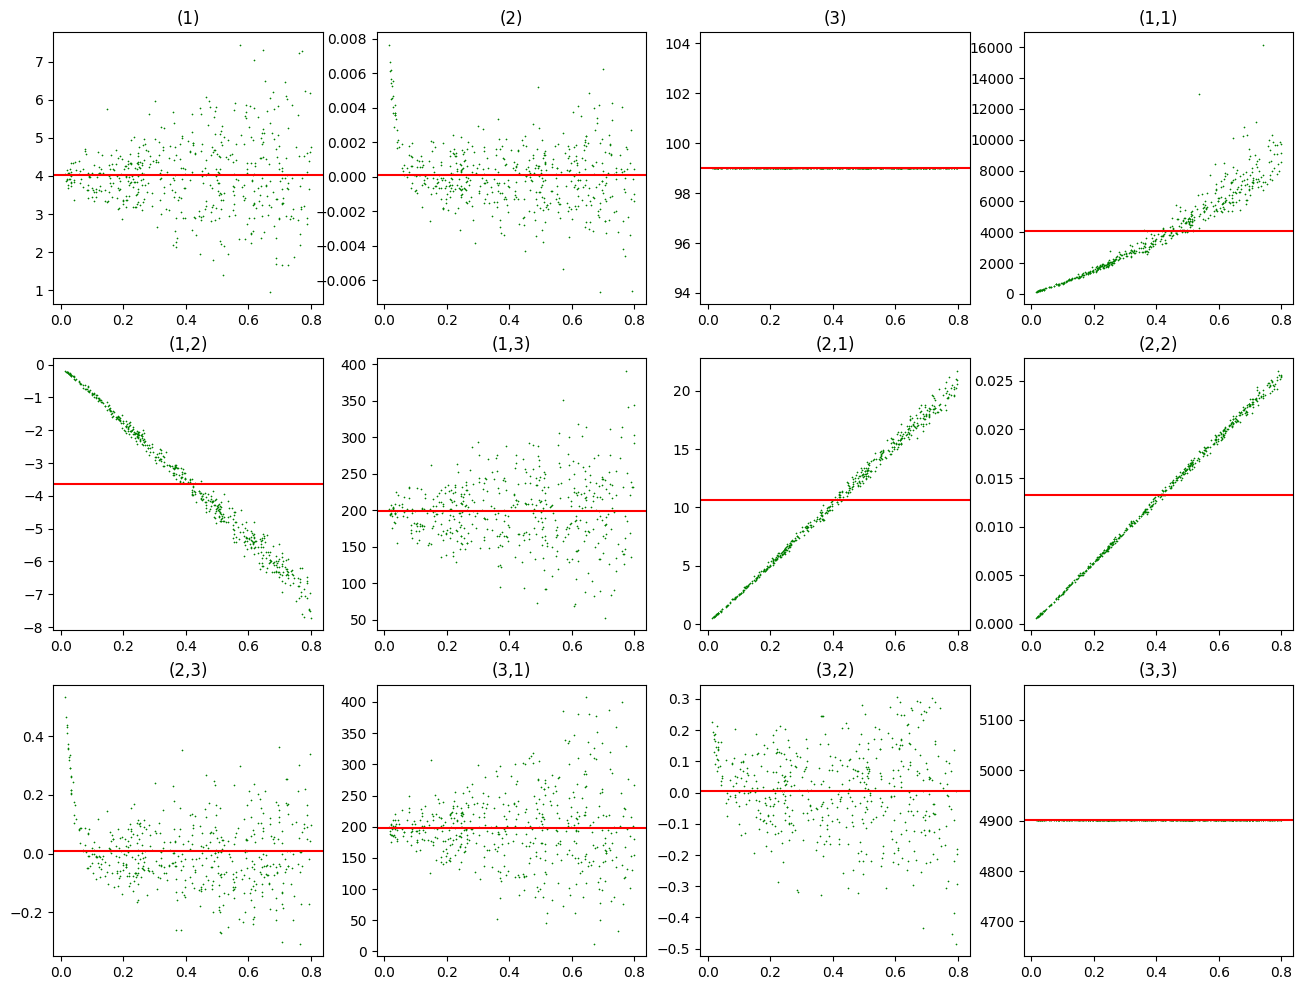

In [62]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(thetas,Exp_signatures_results_thetas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_thetas.T[i]), color='red')

# seems that for most of components we do not have valuable changes
# thus samll rhos has no big influence on expected signature components with variable sigmas

In [63]:
# change rhos to 1.5
thetas= np.random.uniform(0.01,0.8,500) #Long run variance θ
kappas= 2.0 # 2
v_0s = thetas #  Initial variance
rhos = 1.5 #0.6
sigmas = 0.6 #0.6
rs = 0.04 #0.04

S = 100
paths = 10000
steps = 100
T = 1

In [64]:
results_thetas=signatures_calculations_thetas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_thetas=results_thetas[0]
Exp_signatures_results_thetas=results_thetas[1]

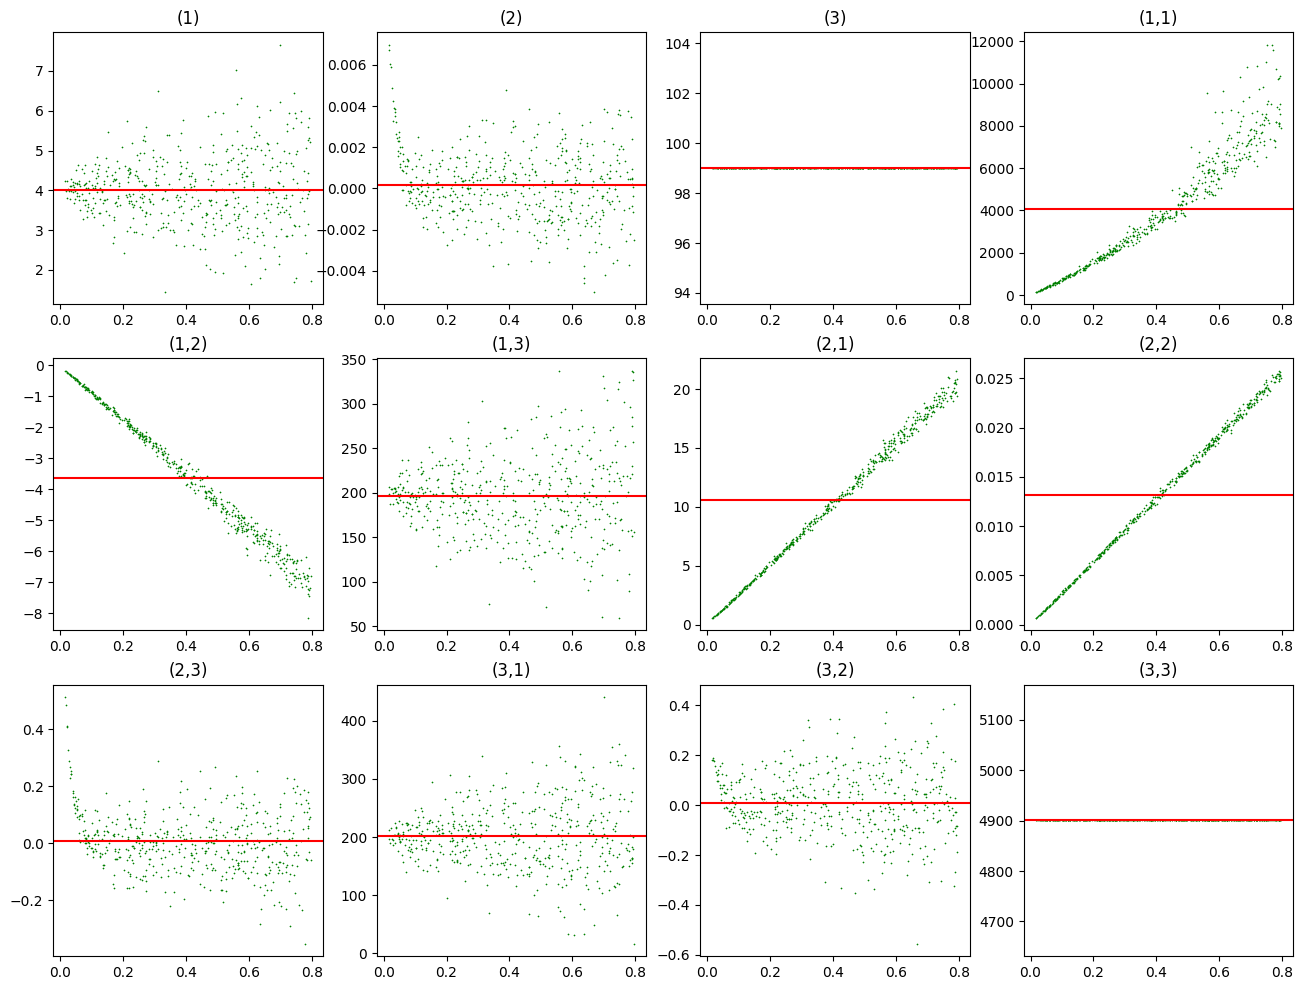

In [65]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(thetas,Exp_signatures_results_thetas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_thetas.T[i]), color='red')

# seems that for most of components we do not have valuable changes, but keys (2) and (3,1)  have  some bigger outliers
# thus big rhos has no big influence on expected signature components with variable sigmas